# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# Packages for Part 0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing packages required for Part 1
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Importing packages required for Part 2
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline
import time

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# load in the data part 2
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# We have a look at the columns 18 and 19 showing an type mismatch error
print(azdias.iloc[:,18:20].columns)
print(customers.iloc[:,18:20].columns)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


### 0.1. Exploration
#### 0.1.1 Investigating the mixed type warning message

For the two columns with look at the list of values and notice than we have a mix of integer, floats (for example 8.0) and also object "X".

In [5]:
# We notice a "X" in the column 'CAMEO_DEUG_2015' which does not match the integer
# Also notiving a mix of floats and integer
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

The same observation is found in the CAMEO_INTL_2015 column. We notice that the number of "XX" matches the number of "X" in the CAMEO_DEUG_2015 column, which we'll investigate further, if all CAMEO columns are showing X values.

In [6]:
# We notice a "XX" in the column 'CAMEO_DEUG_2015' which does not match the integer
# We also notice that count of XX matches the count of X above
# Also noticing a mix of floats and integer
azdias['CAMEO_INTL_2015'].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

I decided to look at all "CAMEO" with X and find that all corresponding are also with "X" values. The shape also matches the 373 values found earlier. Because no information is available and the data definition file the "X" are not described, we will treat them as "unknown" and replace it with nan.

In [7]:
# Looking a the Cameo columns, we see that all categories are not present assuming X
# Proposal: values should be replaced with nan
azdias[azdias['CAMEO_INTL_2015'] == 'XX'][['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']].sample(10)

,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
266100,X,XX,XX
333826,X,XX,XX
717154,X,XX,XX
647510,X,XX,XX
233473,X,XX,XX
736522,X,XX,XX
657102,X,XX,XX
592037,X,XX,XX
272012,X,XX,XX
28123,X,XX,XX


The same observation can be made on the customers dataset and same cleaning procedure will be applied.

In [8]:
# Same observation is valid for customers
customers[customers['CAMEO_INTL_2015'] == 'XX'][['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']]

,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
2625,X,XX,XX
3723,X,XX,XX
9970,X,XX,XX
10233,X,XX,XX
11560,X,XX,XX
12025,X,XX,XX
12360,X,XX,XX
15343,X,XX,XX
15661,X,XX,XX
17767,X,XX,XX


#### 0.1.2 Investigating null in columns

In this section, we will look into columns and rows with high amount of nulls. First we get the average number of nulls for each column and view its distribution.

In [9]:
# Calculate average percentage of Nulls in columns
azdias_null_cols = azdias.isnull().mean(axis=0)
customers_null_cols = customers.isnull().mean(axis=0)

Looking at the distribution below, we see that few columns have a high number of nulls. To build our model, we decided to remove these columns, assuming we will not loose much information.
We chose a threshold dropping the columns having more than 20% null values.

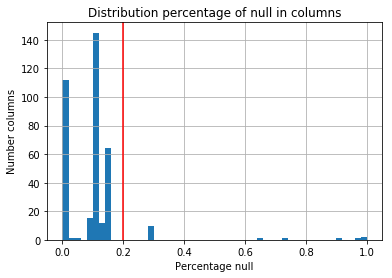

In [10]:
# Distribution of the average amount of null in the columns
azdias_null_cols.hist(bins=50)
plt.title('Distribution percentage of null in columns')
plt.xlabel('Percentage null')
plt.ylabel('Number columns')
# Visualise our chosen threshold of 20% as a vertical line
plt.axvline(0.2, color='red');

We use the same method than above to have a look at the customer dataset. In our customer dataset the percentage of nulls in the columns are slightly higher

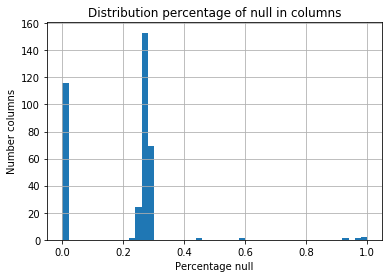

In [11]:
# Plot its distribution
customers_null_cols.hist(bins=50)
plt.title('Distribution percentage of null in columns')
plt.xlabel('Percentage null')
plt.ylabel('Number columns');

#### 0.1.3 Investigating null in rows

In order to perform a clustering, we want to avoid rows with high amount of nulls. In this section we will look at the distribution of the "average percentrage of nulls in rows". Based on the distribution, we will suggest to remove rows with more than 10% of nulls. We assume that little information will lost in the cleaning process. Cleaning will be performed in section 0.2

In [13]:
# Calculate the percentage of nulls for each row
azdias_null_rows = azdias.isnull().mean(axis=1)

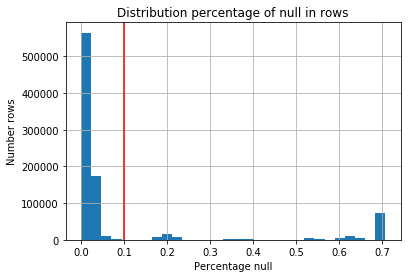

In [14]:
# Plot its distribution
azdias_null_rows.hist(bins=30)
plt.title('Distribution percentage of null in rows')
plt.xlabel('Percentage null')
plt.ylabel('Number rows')
# Display the chosen threshold as vertical line 
plt.axvline(0.1, color='red');

In [15]:
perc_rows_kept = (azdias_null_rows < 0.1).sum() / azdias_null_rows.shape[0] * 100
print('Removing rows with nulls more than 10% leaves us with {:.1f}% of the data'.format(perc_rows_kept))

Removing rows with nulls more than 10% leaves us with 84.2% of the data


To get a feeling for our threshold, I decide to create a function to visualise, how much rows are kept depending on its value. As a reminder, the rows with more nulls than the threshold (%) will be discarded from our data. 

In [16]:
# Creating a function to see the effect of a chosen theshold removing rows 
# with percentage higher than the threshold
def rows_left_null_threshold_graph(df_null_rows):
    '''
    Creates a graphic to see how many rows are kept depending on a threshold.
    Rows with amount of nulls above the threshold will be removed,
    
    Args:
        df_null_rows: pandas dataframe - 2 columns, index and the percentage of nulls in that row
    
    returns: None
        Graphic showing the percentage of kept rows vs. threshold
    
    '''
    threshold = []
    rows_kept = []
    for i in np.arange(0, 1.05, 0.05):
        perc_rows_kept = (df_null_rows < i).sum() / df_null_rows.shape[0] * 100
        threshold.append(i)
        rows_kept.append(perc_rows_kept)

    plt.scatter(x=threshold, y=rows_kept)
    plt.title('Number of rows below threshold')
    plt.xlabel('Row discard threshold')
    plt.ylabel('Percentage of rows kept');
    
    pass

The graphic below shows that with a low threshold, most of the data are still kept and barely increase by allowing more nulls in the rows.

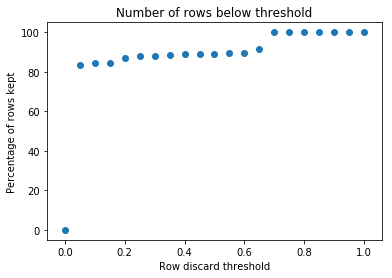

In [17]:
rows_left_null_threshold_graph(azdias_null_rows)

We repeat the same method on the customer dataset and visualise our previously chosen threshold of 10%.

In [19]:
customers_null_rows = customers.isnull().mean(axis=1)

The distribution of the customer dataset show a sightly different shape. We notice that a significant number of rows have more than 60% nulls. To clean these rows, we would have to make quite a few assumption (imputing for ex.). We would probably decide to remove them anyway. The 10% threshold seem to be also here appropriate. 

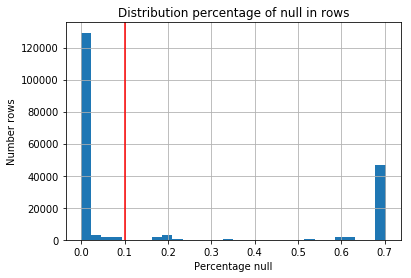

In [20]:
customers_null_rows.hist(bins=30)
plt.title('Distribution percentage of null in rows')
plt.xlabel('Percentage null')
plt.ylabel('Number rows')
plt.axvline(0.1, color='red');

In [21]:
perc_rows_kept = (customers_null_rows < 0.1).sum() / customers_null_rows.shape[0] * 100
print('Removing rows with nulls more than 10% leaves us with {:.1f}% of the data'.format(perc_rows_kept))

Removing rows with nulls more than 10% leaves us with 70.5% of the data


Similar to the population dataset, the customer dataset show that the number of rows stays relatively constant with a low value of the threshold, confirming the choice of 10%.

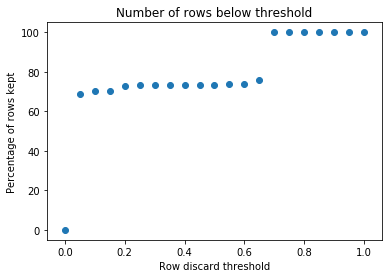

In [22]:
rows_left_null_threshold_graph(customers_null_rows)

### 0.2 Cleaning

#### 0.2.1 Cleaning CAMEO columns

looking at the DIAS attributes, the "X" cannot be assigned to one particular category. We will replace them with np.nan = unknown

In [2]:
def clean_CAMEO(df,
                col_dict={'CAMEO_DEUG_2015' : 'X', 'CAMEO_INTL_2015': 'XX', 'CAMEO_DEU_2015': 'XX'}):
    '''
    replaces the values X, XX, and XXX with np.nan
    change the type of the column to int
    
    Args:
        df: pandas dataframe - to be cleaned
        col_dict: dict - column name with correponding value that we be set to nan
        
    return
        df with colums in col_dicts cleaned 
    '''
    # Loops through the columns and replace the values with nan
    for col_name, value_to_replace in col_dict.items():    
        df[col_name].replace(to_replace=value_to_replace, value=np.NaN, inplace=True)
    
        # change the type of the clean column to float when mixed of int and float
        # leave string type as is
        try:
            df[col_name] = df[col_name].astype('float64')
        except:
            pass
        
    return df

In [24]:
# Clean both datasets for their CAMEO columns
azdias = clean_CAMEO(azdias)
customer = clean_CAMEO(customers)

#### 0.2.2 Cleaning: removing columns with high number of nulls

In section 0.1 we decided to remove all columns with more than 20% of nulls.

In [25]:
# Select the columns with less than 20% nulls
col_to_keep = list(azdias_null_cols[azdias_null_cols < 0.2].index)

In [26]:
# Hint how much features are left
print('This leave us with {} features from {}'.format(len(col_to_keep), azdias_null_cols.shape[0]))

This leave us with 350 features from 366


In [27]:
# Creating 2 dataset with only the column with number of nulls below the threshold
azdias_clean = azdias[col_to_keep]
customers_clean = customers[col_to_keep]

#### 0.2.3 Cleaning: removing rows with high number of nulls

In Section 0.1, we decided to remove all rows with more than 10% of nulls.

In [28]:
# Selecting rows with number of nulls below the threshold.
customers_clean = customers_clean[customers_null_rows < 0.1]
azdias_clean = azdias_clean[azdias_null_rows < 0.1]

We check the final result after our cleaning operations

In [29]:
# Checking shapes
print('Original customers{}'.format(customers.shape))
print('Cleaned customers{}'.format(customers_clean.shape))
# Checking shapes
print('Original population{}'.format(azdias.shape))
print('Cleaned population{}'.format(azdias_clean.shape))

Original customers(191652, 369)
Cleaned customers(135078, 350)
Original population(891221, 366)
Cleaned population(750737, 350)


### 0.3 Dealing with missing values

Now that we have selected for the columns and rows with low nulls values. We would like to see if and how the missing values should be treated. First we have a look at the columns with missing values.

#### 0.3.1 Exploration of missing values & attribute description

In [33]:
# Calculate average percentage of Nulls in columns
azdias_null_cols = azdias_clean.isnull().mean(axis=0)

In [48]:
# Looking at only at the columns with missing values
azdias_null_cols[azdias_null_cols != 0]

ANZ_HH_TITEL           0.004454
ARBEIT                 0.005202
BALLRAUM               0.000705
CAMEO_DEU_2015         0.004799
CAMEO_DEUG_2015        0.004799
CAMEO_INTL_2015        0.004799
CJT_GESAMTTYP          0.005108
CJT_KATALOGNUTZER      0.005108
CJT_TYP_1              0.005108
CJT_TYP_2              0.005108
CJT_TYP_3              0.005108
CJT_TYP_4              0.005108
CJT_TYP_5              0.005108
CJT_TYP_6              0.005108
EWDICHTE               0.000705
FIRMENDICHTE           0.000007
GEBAEUDETYP_RASTER     0.000007
GEMEINDETYP            0.005279
GFK_URLAUBERTYP        0.005108
HH_DELTA_FLAG          0.041936
INNENSTADT             0.000705
KKK                    0.009697
KONSUMNAEHE            0.000065
KONSUMZELLE            0.000007
LP_FAMILIE_FEIN        0.005108
LP_FAMILIE_GROB        0.005108
LP_LEBENSPHASE_FEIN    0.005108
LP_LEBENSPHASE_GROB    0.005108
LP_STATUS_FEIN         0.005108
LP_STATUS_GROB         0.005108
ONLINE_AFFINITAET      0.005108
ORTSGR_K

Looking for the best method for imputing values for each columns. We notice that not all the attribute in the dataset are described in the attribute definition file, making an interpretation of the results difficult or impossible. We decide to remove the columns not described. We have noticed one exception from our exploration earlier. The column 'CAMEO_INTL_2015' corresponds to the attribute 'CAMEO_DEUINTL_2015' in our attribute list.

For that purpose we created a csv file with the list of described columns from both excel files explaining the attributes. We will then assess, how many are described and in the next step remove the unknown attributes. 

In [3]:
# Loading the described attribute list from csv file
described_attributes = pd.read_csv('attribute_list.csv', sep=';')

In [4]:
# Creating a list of all described columns
described_attributes_list = list(described_attributes['Attribute'])

Compairing both lists, we see that only 269 columns are described from the 350 originally kept after cleaning.

In [81]:
# create a list with all columns in common
common_cols = np.intersect1d(list(azdias_clean.columns), described_attributes_list)
print('We have {} columns in our dataset, which only {} are described.'.format(len(azdias_null_cols), len(common_cols)))

We have 273 columns in our dataset, which only 269 are described.


#### 0.3.2 Cleaning non described attributes

As noticed in the previous section, we only keep the columns which are described in the attribute definition files.

In [82]:
# Only keeping the common columns, determined in the previous section
azdias_clean = azdias_clean[common_cols]
customers_clean = customers_clean[common_cols]

#### 0.3.3 Resume exploring of missing values

We resume our exploration after only keeping the described attributes.
We gather all columns from both dataset including nulls values. After a manual check, in the DIAS attributes file, all columns are categorical and not numeric.
We will choose to replace the null using the mode of each column.  

In [103]:
# Calculating the average nulls in our dataset
azdias_null_cols = azdias_clean.isnull().mean(axis=0)
# Looking at only at the columns with missing values
azdias_imputed_cols = azdias_null_cols[azdias_null_cols != 0]
# Calculating the average nulls in our dataset
customer_null_cols = customers_clean.isnull().mean(axis=0)
# Looking at only at the columns with missing values
customer_imputed_cols = customer_null_cols[customer_null_cols != 0]
# Gather columns from both dataset to be imputed cols
imputed_cols = set(azdias_imputed_cols.index) | set(customer_imputed_cols.index)

In [113]:
# Check list
imputed_cols

{'ANZ_HH_TITEL',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'EWDICHTE',
 'GEBAEUDETYP_RASTER',
 'GFK_URLAUBERTYP',
 'INNENSTADT',
 'KKK',
 'KONSUMNAEHE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'ONLINE_AFFINITAET',
 'ORTSGR_KLS9',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'REGIOTYP',
 'RELAT_AB',
 'RETOURTYP_BK_S',
 'W_KEIT_KIND_HH'}

#### 0.3.4 Imputing the mode  

As defined in the previous section, We will impute the mode for the columns identified in the previous section and stored in a set "imputed_cols".
We write a function to perform the imputation. We could have used alternatively the SimpleImputer() Class from sklearn with "most_frequent".

In [5]:
def impute_mode(df, imputed_cols):
    ''' Impute the mode to the "cols" columns
    
    Args:
        df: pandas Dataframe that need to be cleaned
        imputed_cols: list of columns where the mode will be imputed
    
    Returns:
        df: pandas Dataframe - df with imputed mode for each imputed_columns 
    
    Hint: print message alerts, if imputing not possible
    '''
    
    # Loop through the columns
    for col in imputed_cols:
        try:
            df[col] = df[col].fillna(df[col].value_counts().index[0])
        except:
            print("Column {} not in the dataset or imputing not possible".format(col))
    
    return df

In [118]:
# Imputing the mode for azdias
azdias_imputed = impute_mode(azdias_clean, imputed_cols)

In [119]:
# Imputing the mode for customers
customers_imputed = impute_mode(customers_clean, imputed_cols)

#### 0.4 Putting it all together

In this section with will take all the steps above and put it into one function cleaning our Datasets.

In [6]:
def select_described_cols(df, described_cols=described_attributes_list):
    ''' Select only columns which have been described
    Args:
        df: pandas dataframe
        described_cols: list of column names which are described
    
    Returns:
        df_clean: pandas dataframe with described cols
    '''
    # create a list with all columns in common
    described_cols = np.intersect1d(list(df.columns), described_attributes_list)
    df_clean = df[described_cols]

    return df_clean

def clean_null_cols(df, threshold_cols=0.2):
    ''' Select only columns which have lower percentage of nulls
    than the threshold
    
    Args:
        df: pandas dataframe
        threshold_cols: float - columns with higher null percentage will be removed
    
    Returns:
        df_clean: pandas dataframe with described cols
    '''
    # Calculate the anount of null in columns
    df_null_cols = df.isnull().mean(axis=0)
    # Select the columns with less than threshold_col nulls
    col_to_keep = list(df_null_cols[df_null_cols < threshold_cols].index)
    df_clean = df[col_to_keep]
    
    return df_clean

def clean_null_rows(df, threshold_rows=0.1):
    ''' Select only rows which have lower percentage of nulls
    than the threshold
    
    Args:
        df: pandas dataframe
        threshold_rows: float - rows with higher null percentage will be removed
    
    Returns:
        df_clean: pandas dataframe with described cols
    '''
    # Calculate the anount of null in row
    df_null_rows = df.isnull().mean(axis=1)
    # Select the rows with less than threshold_rows nulls
    df_clean = df[df_null_rows < threshold_rows]
    
    return df_clean

In [52]:
def cleaning_imputing(df,
                      described_attributes_list=described_attributes_list,
                      threshold_col=0.2,
                      threshold_rows=0.1):
    '''
    Clean CAMEO columns
    Removing rows and columns with higher nulls values than their thresholds
    Imputing mode for the columns with null values
    
    Args:
        azdias: pandas Dataframe - 
        customers: pandas - Dataframe -
        threshold_col: float - columns with more null percentage will be removed
        threshold_rows: float - rows with more null percentage will be removed
        
    Returns:
        df_cleaned: pandas Dataframe cleaned & imputed
    '''
    # ## STEP 1: Clean Cameo
    # Clean both datasets for their CAMEO columns
    df_clean = clean_CAMEO(df)
    
    # ## STEP 2: Only keep described columns
    df_clean = select_described_cols(df_clean)
    
    # ## STEP 3: Remove columns with number of nulls higher threshold
    # Select the columns with less than threshold_col nulls
    df_clean = clean_null_cols(df_clean, threshold_col)

    # ## STEP 4: Remove rows with number of nulls higher threshold
    # Calculate the percentage of nulls for each row
    df_clean = clean_null_rows(df_clean, threshold_rows)

    # ## STEP 5: Impute mode for columns with nan
    # Re-Calculating the average nulls in azdias dataset after row cleaning
    df_null_cols = df_clean.isnull().mean(axis=0)
    # Looking at only at the columns with missing values
    imputed_cols = df_null_cols[df_null_cols != 0]
    # Imputing the mode for azdias
    df_imputed = impute_mode(df_clean, imputed_cols.index)
    
    return df_imputed

In [ ]:
azdias_imputed = cleaning_imputing(azdias,
                                   described_attributes_list=described_attributes_list,
                                   threshold_col=0.2,
                                   threshold_rows=0.1)

customers_imputed = cleaning_imputing(customers,
                                      described_attributes_list=described_attributes_list,
                                      threshold_col=0.2,
                                      threshold_rows=0.1)

#### 0.5 Saving cleaned dataset

We save both cleaned dataset for further use in Section 1

In [120]:
customers_imputed.to_pickle('./customers_clean_imputed.pkl')

In [121]:
azdias_imputed.to_pickle('./azdias_clean_imputed.pkl')

#### 0.5. Conclusion
- We have cleaned the 3 CAMEO columns replacing the "X" and "XX" with NaN and corrected the type.
- Given our investigating we decided of 2 threshold and discard rows / columns with following logic:
    - removing columns with more than 20% of nulls
    - removing rows with nore than 10% of nulls
- We only selected attributes / columns that are described in the DIAS Attributes.
- We treated the missing values by imputing the mode in the categorical attributes.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

We intend in this section to group the population into groups or clusters and compare the distribution of the cluster for a customers compared to the population itself. The differences mights give us insights about the important features of our customer base.
We will process as follow, following a post seen here https://365datascience.com/tutorials/python-tutorials/pca-k-means/
- PCA
- K-means

### 1.0 Loading cleaned data

In [7]:
# Loading Data after cleaning - from Part 0
customers_clean = pd.read_pickle('./customers_clean_imputed.pkl')
azdias_clean = pd.read_pickle('./azdias_clean_imputed.pkl')

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
list(customers_clean.columns)

['AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EWDICHTE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER',
 'GEBAEUDETYP',
 'GEBAEUDETYP_RASTER',
 'GEBURTSJAHR',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTG

### 1.1. Prepocessing Encoding categorical variables

In Order for the PCA to perform well, we want to scale the features. 

In this dataset we have 4 types of variables:
- numerical: as int or float like ANZ_HAUSHALTE_AKTIV number of households in the building
- Ordinal: showing an order in the values taken, like BALLRAUM distance to next urban centre. Low values are closer to the center than higher ones.
- Categorical: like ANREDE_KZ or gender encoded as 1 or 2.
- Flags: already encoded with 0 or 1

From these 4 type, we only need to encode the categorical ones in order to be able to scale them. The ordinal, flags and numerical can be scaled as is.

For that purpose, I added a "type" column to the "described attribute list" from section 0.3 with the corresponding type.

In [10]:
# Loading the described attribute list from csv file
described_attributes = pd.read_csv('attribute_list.csv', delimiter=';')

In [11]:
# Looking at the distribution of our type
described_attributes['type'].value_counts()

ordinal        293
categorical     11
numeric          7
flag             3
Name: type, dtype: int64

We need to encode only the "categorical" columns and use the one hot encoder method.

In [12]:
# Creating a list of the categorical attributes
cols_one_hot = list(described_attributes[described_attributes['type'] == 'categorical']['Attribute'])
cols_one_hot

['AGER_TYP',
 'ANREDE_KZ',
 'CAMEO_DEU_2015',
 'GFK_URLAUBERTYP',
 'HEALTH_TYP',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_GROB',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP']

In [13]:
# One hot encoding the categorical variables
azdias_encoded = pd.get_dummies(azdias_clean, columns=cols_one_hot)
customers_encoded = pd.get_dummies(customers_clean, columns=cols_one_hot)

In [14]:
print('we have now {} features for the population and {} for the customers'.format(azdias_encoded.shape[1], customers_encoded.shape[1]))

we have now 361 features for the population and 361 for the customers


In [15]:
# Creating a list of all features
feature_list = azdias_encoded.columns

### 1.2 Scaling

Now that the categorical variables have been encoded, we can scale them.

In [16]:
# Initiate Scaler
scaler = StandardScaler()

In [17]:
# Scale features for both dataset
customers_std = scaler.fit_transform(customers_encoded)

In [18]:
# Scale features for both dataset 
azdias_std = scaler.fit_transform(azdias_encoded)

In [19]:
# customers_std.to_pickle('./customers_std.pkl')
# azdias_std.to_pickle('./azdias_std.pkl')

### 1.3 PCA

Now that the features have been scaled, we can perform a PCA. In a first step, we want to see how many components, we want to keep in order to explain approx. 80% of the variance (rule of thumb).

Create and fit the model

In [20]:
# Initiate the PCA
pca = PCA()
pca.fit(azdias_std)

PCA()

The explained variance is explained in an array explained_variance_ratio_ sorted from most to least important.

In [21]:
pca.explained_variance_ratio_

array([7.20800402e-02, 6.13050536e-02, 4.37347777e-02, 3.57836486e-02,
       2.67178874e-02, 2.17977260e-02, 2.09944718e-02, 1.56620932e-02,
       1.43042653e-02, 1.30090492e-02, 1.24392978e-02, 1.18242044e-02,
       1.11900414e-02, 1.05381803e-02, 9.15259643e-03, 9.04697812e-03,
       8.55476997e-03, 7.87023746e-03, 7.58954046e-03, 7.46743670e-03,
       7.00052475e-03, 6.90592592e-03, 6.53604784e-03, 6.32181479e-03,
       6.26447191e-03, 6.04643251e-03, 5.96223190e-03, 5.76143229e-03,
       5.61551904e-03, 5.34125819e-03, 5.21609814e-03, 5.16798916e-03,
       5.13545542e-03, 5.00135333e-03, 4.90792603e-03, 4.83205774e-03,
       4.79296927e-03, 4.65193740e-03, 4.53268657e-03, 4.45355566e-03,
       4.41005427e-03, 4.35941562e-03, 4.27711085e-03, 4.17560168e-03,
       4.11213980e-03, 4.00941517e-03, 3.95539174e-03, 3.89911312e-03,
       3.86608536e-03, 3.77202208e-03, 3.76413765e-03, 3.73135229e-03,
       3.68069742e-03, 3.62580210e-03, 3.56635169e-03, 3.48534561e-03,
      

If we want to keep 80% of the variance, we have to keep the first 127 components (see formula below).

In [22]:
(pca.explained_variance_ratio_.cumsum()<0.8).sum()

127

In this graph we can see how the variance can be explained with a growing number of components.

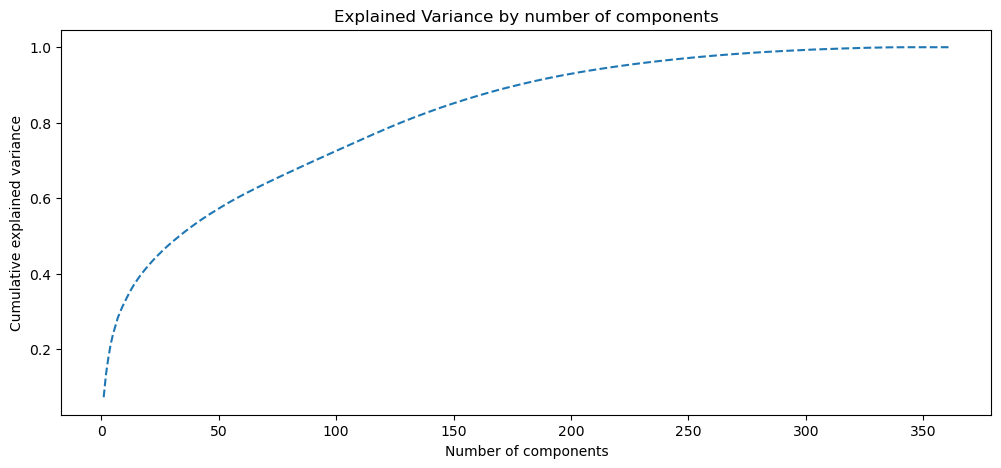

In [23]:
plt.figure(figsize=(12,5))
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), linestyle = '--')
plt.title('Explained Variance by number of components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

We repeat the fitting of the PCA with the number of components determined above and keep 80% of the variance from the original dataset.

In [24]:
# Initiate the PCA
pca = PCA(n_components = 127)
pca.fit(azdias_std)

PCA(n_components=127)

In [25]:
# Transforming the scaled azdias with pca 
azdias_pca = pca.transform(azdias_std)

In [26]:
# Transforming the scaled customers with pca
customers_pca = pca.transform(customers_std)

In Order to interpret the results later, we build a corresponding matrix between pca components & features

In [27]:
# Creating PCA / Feature matrix
df_pca_feature_matrix = pd.DataFrame(pca.components_, columns=feature_list)

### 1.4 Building clusters using K-Means & pca transformed data

We want to investigate how many clusters are necessary in our next step

In [28]:
# We fit K-Means using the pca transformed data and calculate the wcss (within-cluster sums of squares)
results = []
for i in range(1,15):
    kmeans_pca = KMeans(n_clusters = i, random_state = 42)
    kmeans_pca.fit(azdias_pca)
    results.append(kmeans_pca.inertia_)

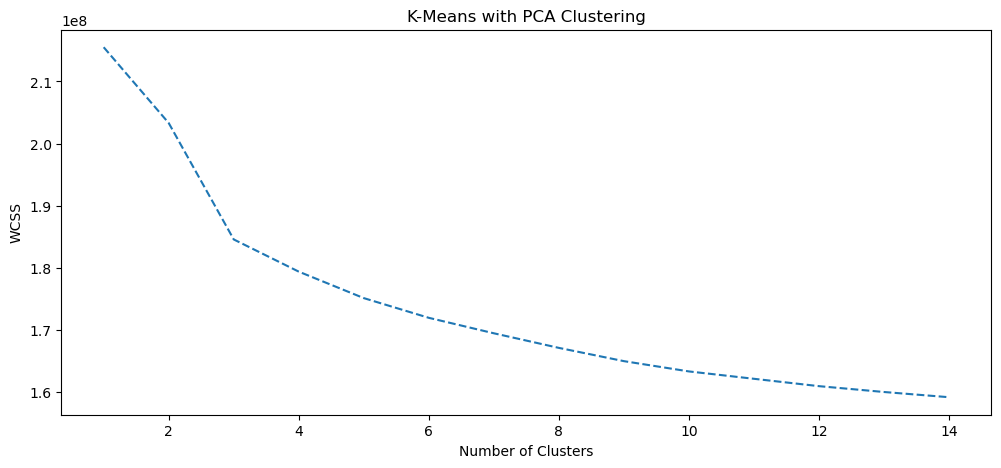

In [29]:
plt.figure(figsize=(12,5))
plt.plot(range(1,15), results, linestyle = '--')
plt.title('K-Means with PCA Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS');

From this graphic we want to determine how many cluster we should keep. We use the elbow method. Based on this method, I would suggest to use xx clusters. Which will be implementing in the next section.

### 1.5 Building KMeans model

We choose from the section above 10 clusters

In [30]:
# Building the model using 10 cluster
kmeans = KMeans(n_clusters = 10, random_state = 42)
kmeans.fit(azdias_pca)

KMeans(n_clusters=10, random_state=42)

In [31]:
# Building the clusters for azdias
azdias_clusters = kmeans.predict(azdias_pca)

In [32]:
# Builing the clusters for customers
customers_clusters = kmeans.predict(customers_pca)

### 1.6 Compairing the clusters

In a first stept, we want to compaire the distribution of both datasets with regards to the clusters.

In [33]:
# Transforming the results to pandas series in order to use value_counts
azdias_clusters = pd.Series(azdias_clusters)
customers_clusters = pd.Series(customers_clusters)

We create here a function to see what percentage of the rows are assigned to which cluster

In [34]:
def cluster_distribution(df, source='azdias'):
    ''' Returns the percentage of rows for each cluster for the given dataset
    Args:
        df: pandas Series of cluster number
        source: str - name of the source will be added in "source" column
        
    returns
        df_cluster: pandas Dataframe 
    '''
    # Calculate the frequency of each cluster
    df_cluster = df.value_counts()
    # change the name of index
    df_cluster.index.name = 'cluster'
    # Calculate percentage
    df_cluster = df_cluster / df_cluster.sum()
    # Calculate rename the output column in perc
    df_cluster = df_cluster.reset_index(name=source)
    
    return df_cluster

Applying the function to both datasets and concatenate both to show them into one graphic

In [35]:
# Calculate cluster distributions
cluster_dist_azdias = cluster_distribution(azdias_clusters, 'azdias')
cluster_dist_customers = cluster_distribution(customers_clusters, 'customers')
# Concatenate the results
cluster_dist = pd.merge(cluster_dist_azdias, cluster_dist_customers, on=['cluster'], how='left')
# Sorting the values for graphic
cluster_dist = cluster_dist.sort_values(by='cluster')

We can compare which percentage of the population and our customers are falling in which cluster. From the graphic below, we see that our customers belong most to **Cluster 3** and **9**.   

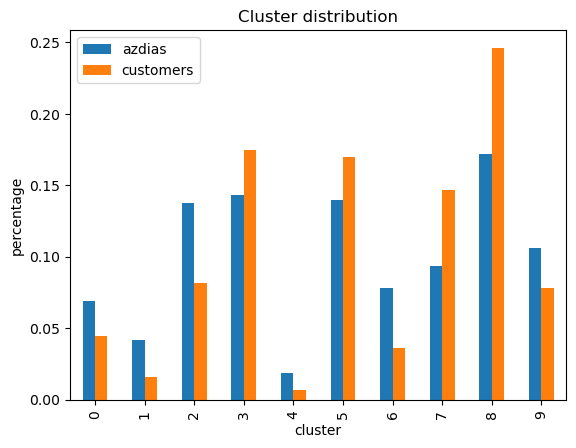

In [36]:
# Create graph
cluster_dist.plot(x='cluster',
                  kind='bar',
                  stacked=False,
                  title='Cluster distribution',
                  ylabel='percentage');

I finded hard by looking at the graphic above to make sure, I captured the differences the best. I decided to create the ratio between both percentage. A ratio of 1 being egal distribution, > 1 being more present in our customer base. We confirm the cluster 3 and 9 being important in the customer base and the low ratio values for cluster 0 and 1. We dismiss cluster 4, because of its size.

In [37]:
# Calculating ratio
cluster_dist['ratio'] = cluster_dist['customers'] / cluster_dist['azdias']

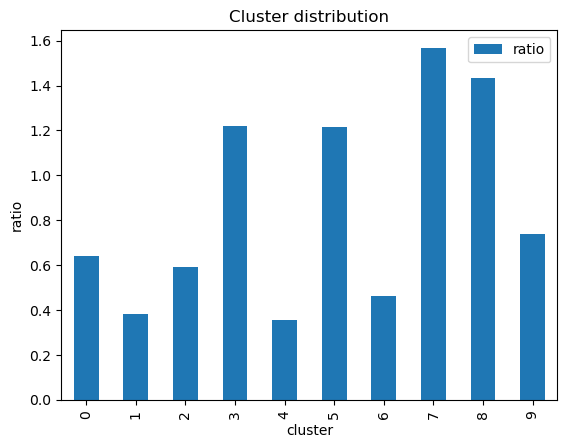

In [38]:
# Plotting the ratio
cluster_dist.plot(x='cluster',
                  kind='bar',
                  y='ratio',
#                   stacked=False,
                  title='Cluster distribution',
                  ylabel='ratio');

### 1.7 Cluster analysis: what are the main differences?

We will look at the meaning behind the cluster identified above (Cluster 3 and 9) and look at the corresponding features. We will look in a second step the cluster 0 and 1 which seems to be not present in our customer base.

First we write a function to "translate" our cluster from their PCA values back to their underlying features. We will sort the features by weight.

#### 1.7.1. Data Preparation - Feature importance per Cluster

In [39]:
def cluster_most_important_features(kmeans_model=kmeans, pca_model=pca, feature_list=feature_list, n_features=5):
    '''
    Calculate the most import features for a all clusters of a given KMeans model
    trained using the pca_model
    
    Args:
        kmeans_model: trained KMeans model
        pca_model: trained pca model used to train the KMeans model
        feature_list: array str - list of the feature names used for the PCA
        n_features: int - number of top and bottom features to extract
    
    Returns:
        cluster_feature_list: dict
            dict key: cluster number
            dict value: list of feature and corresponding weights sorted by weight
    
    '''
    # Initiate an empty dictionary
    cluster_feature_list={}
    
    # iterate through the clusters
    for i in range(0,kmeans_model.__dict__['_n_features_out']):
        # add most important features to dictionary 
        cluster_feature_list[i] = most_important_features(kmeans_model=kmeans,
                                                                       pca_model=pca,
                                                                       cluster_number=i,
                                                                       feature_list=feature_list,
                                                                       n_features=n_features)
    
    return cluster_feature_list

def most_important_features(kmeans_model=kmeans,
                            pca_model=pca,
                            cluster_number=0,
                            feature_list=feature_list,
                            n_features=5):
    '''
    Calculate the most import features for a given cluster
    
    Args:
        kmeans_model: trained KMeans model
        pca_model: trained pca model used to train the KMeans model
        cluster_numer: int - number of the cluster
        feature_list: array str - list of the feature names used for the PCA
        n_features: int - number of top and bottom features to extract
    
    Returns:
        feature_weights_sorted: pandas Series - list of feature and corresponding weights
    
    '''
    # Select pca weights for the cluster "cluster_number"
    cluster_pca = kmeans_model.__dict__['cluster_centers_'][cluster_number]
    # Reverse back to the feature list
    cl_feature_weights = pca.inverse_transform(cluster_pca)
    
    # Create a series of feature weights and add feature names
    # Sorting values
    feature_weights_sorted = pd.Series(cl_feature_weights, index=feature_list).sort_values()

    # Selecting only most significant features
    top_features_weights = pd.concat([feature_weights_sorted.nlargest(n_features),
                                     feature_weights_sorted.nsmallest(n_features)])
    
    return top_features_weights

In [40]:
cluster_feature_dict = cluster_most_important_features(kmeans_model=kmeans,
                                                       pca_model=pca,
                                                       feature_list=feature_list,
                                                       n_features=5)

#### 1.7.2 Analysis high ratio customer base: Cluster 3, Cluster 9 

Looking at our Cluster 3 we notice that the amount of customer with higher financial interest ("low financial interest" is low). Both LP_Status indicates higher incomes and settled (moving pattern low). FINANZ_SPARER is also consistent with a high saving (low value = high saving)

In [41]:
cluster_feature_dict[3]

LP_LEBENSPHASE_GROB_2.0    0.952943
ZABEOTYP_3                 0.805563
FINANZ_VORSORGER           0.789361
HH_EINKOMMEN_SCORE         0.667597
CAMEO_INTL_2015            0.660635
ONLINE_AFFINITAET         -0.765375
PRAEGENDE_JUGENDJAHRE     -0.708545
LP_STATUS_FEIN            -0.705593
FINANZ_UNAUFFAELLIGER     -0.668748
MOBI_REGIO                -0.663852
dtype: float64

Looking at our Cluster 9, we notice at lot of "car features" from higher specification (high share of BMW, Mercedes) and top speed higher than 211 or more than 121 kW.

In [42]:
cluster_feature_dict[9]

PLZ8_BAUMAX             1.422762
KBA13_HALTER_35         1.343545
PLZ8_ANTG4              1.291146
KBA13_ALTERHALTER_45    1.228089
KBA13_HALTER_40         1.175002
KBA13_AUTOQUOTE        -1.276828
PLZ8_ANTG1             -1.201554
KBA13_ALTERHALTER_60   -1.143806
KBA13_HALTER_60        -1.100330
KBA13_HALTER_55        -1.071361
dtype: float64

#### 1.7.3 Analysis low  ratio customer base: Cluster 0, 1

Cluster 0 are customer from East germany, with a high numer of 5 seats car with junger car owner (21-25 year old) and higher proportion of asian car, low proportion of upper mid class cars. This seem to be all an indication from the East side of germany with lower car segment class than the west of germany. 

In [43]:
cluster_feature_dict[0]

OST_WEST_KZ_O                  1.749810
KBA13_SITZE_5                  1.547139
KBA13_HALTER_25                1.368285
KBA13_HALTER_20                1.159831
KBA13_ALTERHALTER_30           1.082775
OST_WEST_KZ_W                 -1.749810
KBA13_SITZE_4                 -1.498685
KBA13_HERST_BMW_BENZ          -1.370043
KBA13_SEG_OBEREMITTELKLASSE   -1.307046
KBA13_MERCEDES                -1.265878
dtype: float64

Cluster 1 seem to gather most of the "unknown" (values -1). This obviously should be cleaned and feed back to our cleaning function from Part 0 (imputing the mode seem the right choice here). Because this cluster is "small", we will accept this mistake but make a note of it.

In [44]:
cluster_feature_dict[1]

HEALTH_TYP_-1              4.436447
SHOPPER_TYP_-1             4.436447
NATIONALITAET_KZ_0         4.362717
LP_LEBENSPHASE_GROB_0.0    1.981409
SEMIO_REL                  1.345973
VERS_TYP                  -3.561128
NATIONALITAET_KZ_1        -2.165930
PRAEGENDE_JUGENDJAHRE     -1.072282
SEMIO_VERT                -0.864750
FINANZ_MINIMALIST         -0.824814
dtype: float64

### 1.8. Conclusion

From our Analysis above we could segment our population in 10 clusters. Main differences between our customer base and the population were found in Cluster 3, 9 and 0, 1.<br>

Analysing the features of our clusters show:
- geographical differences (west Germany vs. East)
- income (higher income, higher specification of cars
- finances interests (financially interested, higher savings).

This leads us to believe our customer base is wealthier than the "normal" population.

__Hint__: the effects seen above are most likely to be correlated. West Germany is generally speaking wealthier than the East. Purchasing power is reflected in car ownership.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [45]:
# Reading from Desktop
mailout_train = pd.read_pickle('./mailout.pkl')

In [5]:
# Reading from Workspace
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv'

In [46]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

### 2.1 Cleaning our data
The data needs to be cleaned in the same way, we have done in Part 0. We have added in Part 1 an one hote encoding for categorical variables, which will be using here also.

We have seen "unknow" values in the previous question and decide to remove them before we go into our model.

In [47]:
# Replace unknown values encoded as -1 with NaN
mailout_train = mailout_train.replace(-1, np.NaN)

In [48]:
# Adding the RESPONSE column as part of our "described" columns to avoid cleaning
described_attributes_list.append('RESPONSE')

Reuse the function from part 1 to clean and impute the values of our trained dataset

In [53]:
# Cleaning and imputing values
mailout_train_imputed = cleaning_imputing(mailout_train)

One hot encoding

In [54]:
# Select columns from our mailout which need one hot encoding
mailout_one_hot_cols = np.intersect1d(cols_one_hot, mailout_train_imputed.columns)

In [55]:
# One hot encoding the categorical variables
mailout_train_encoded = pd.get_dummies(mailout_train_imputed, columns=mailout_one_hot_cols)

We notice that after our row cleaning, we have lost some of the Responses, however the rate of positive responses remains stable 1.25% (532 out of 42430) to 1,25% (435 out of 34565) 

In [56]:
mailout_train_encoded['RESPONSE'].value_counts()

0    34565
1      435
Name: RESPONSE, dtype: int64

In [57]:
mailout_train_encoded.shape

(35000, 294)

In [199]:
# mailout_train_encoded.to_pickle('./mailout_encoded.pkl', protocol=3)

In [2]:
# mailout_train_encoded.to_csv('./mailout_encoded.csv')

NameError: name 'mailout_train_encoded' is not defined

In [58]:
mailout_train_encoded.describe()

,ALTERSKATEGORIE_GROB,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_HERSTTEMP,KBA05_MODTEMP,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RESPONSE,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0

### 2.2 Evalution metric

We have a highly unbalanced dataset with ca. 1.25% of "positive". Using the accuracy as a metric would not be suitable. Using a "naive" predictor with "negative" would reach accuracy of 98.75% (100% - 1.25%).

https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5

### 2.3. Scaling and splitting the data

As of part 1, we want to scale the data before we use it in the model. We split response and features.

In [3]:
# mailout_train_encoded = pd.read_pickle('mailout_encoded.pkl')
mailout_train_encoded = pd.read_csv('./mailout_encoded.csv')

In [6]:
mailout_train_encoded.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
df_response_yes = mailout_train_encoded[mailout_train_encoded['RESPONSE'] == 1]
df_response_no = mailout_train_encoded[mailout_train_encoded['RESPONSE'] == 0]

In [10]:
df_response_yes.shape

(435, 301)

In [11]:
df_response_no.shape

(34565, 301)

In [12]:
# Create Reponse variable
y = mailout_train_encoded['RESPONSE']
# Features
X = mailout_train_encoded.drop('RESPONSE', axis=1)

In [13]:
# Initiate Scaler
scaler = StandardScaler()
# Perform scaling on the features
X_scaled = scaler.fit_transform(X)

In [14]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [15]:
X_scaled.describe()

,ALTERSKATEGORIE_GROB,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,...,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
count,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,...,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04
mean,4.986741e-16,2.598525e-16,-2.078272e-15,1.592873e-15,-1.042772e-15,1.305436e-15,5.685167e-16,-7.887532e-16,8.212796e-16,-1.289254e-16,...,-1.276392e-15,-1.370053e-15,1.946443e-16,1.346275e-15,-1.307627e-15,1.290512e-15,-1.058353e-15,-2.669198e-16,1.322434e-15,1.325687e-15
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,...,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-3.106996e+00,-1.694573e+00,-4.454055e-01,-1.314716e-01,-1.486084e+00,-9.172763e-02,-1.486050e+00,-1.640683e+00,-1.472826e+00,-1.233210e+00,...,-4.553620e-01,-5.914727e-01,-4.655257e-01,-7.813631e-01,-5.597067e-01,-2.095319e-01,-1.103184e+00,-3.640094e-01,-8.915376e-02,-2.185117e-01
25%,-6.443649e-01,-3.789325e-01,-3.786995e-01,-1.314716e-01,-7.511474e-01,-9.172763e-02,-1.030370e+00,-8.128792e-01,-6.956942e-01,-5.734570e-01,...,-4.553620e-01,-5.914727e-01,-4.655257e-01,-7.813631e-01,-5.597067e-01,-2.095319e-01,-1.103184e+00,-3.640094e-01,-8.915376e-02,-2.185117e-01
50%,5.869505e-01,-5.002252e-02,-3.119935e-01,-1.314716e-01,-1.621060e-02,-9.172763e-02,3.366693e-01,1.492411e-02,-5.985931e-02,-5.734570e-01,...,-4.553620e-01,-5.914727e-01,-4.655257e-01,-7.813631e-01,-5.597067e-01,-2.095319e-01,9.064674e-01,-3.640094e-01,-8.915376e-02,-2.185117e-01
75%,5.869505e-01,7.722526e-01,2.153651e-02,-1.314716e-01,7.187261e-01,-9.172763e-02,7.923491e-01,8.427275e-01,8.585688e-01,7.460483e-01,...,-4.553620e-01,1.690695e+00,-4.655257e-01,1.279815e+00,-5.597067e-01,-2.095319e-01,9.064674e-01,-3.640094e-01,-8.915376e-02,-2.185117e-01
max,6.743527e+00,1.758983e+00,2.877183e+01,5.435647e+01,1.615240e+01,1.913263e+01,1.248029e+00,1.670531e+00,1.565052e+00,2.065554e+00,...,2.196055e+00,1.690695e+00,2.148109e+00,1.279815e+00,1.786650e+00,4.772544e+00,9.064674e-01,2.747182e+00,1.121658e+01,4.576415e+00


The dataset is imbalanced, we need to make sure during training / testing that we have roughly the same amount of "reponses" yes / no in both, using the "stratify" option from train_test_split

In [16]:
# Splitting the data making sure we split the reponses between train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, test_size=0.3, random_state=42)

In [17]:
X_train.shape, X_test.shape

((24500, 300), (10500, 300))

In [18]:
y_train.shape, y_test.shape

((24500,), (10500,))

In [46]:
# Checking response for training set
y_train.value_counts() 

0    24195
1      305
Name: RESPONSE, dtype: int64

In [47]:
# Checking response for testing set
y_test.value_counts()

0    10370
1      130
Name: RESPONSE, dtype: int64

### 2.4 Setting our benchmark

Before trying more complex model, we want to see how a simple model would perform, we choose for that purpose a LogisticRegression.

In [110]:
Lreg = LogisticRegression(random_state=42)
Lreg.fit(X_train, y_train)

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [111]:
roc_auc_score(y_train, Lreg.predict_proba(X_train)[:,1])

0.8054967324911326

In [112]:
print("LogisticRegression - Benchmark: ROC-AUC: {:.2f}".format(roc_auc_score(y_test, Lreg.predict_proba(X_test)[:,1])))

LogisticRegression - Benchmark: ROC-AUC: 0.57


Our Benchmark achieve a score of 0.57, which will try to improve using other models.

### 2.5 Model selection

We will try a series of models in their standard configuration, then in a second step use hyperparameter tuning for the best one.
The selection was inspired from the sklearn documentation https://scikit-learn.org/stable/supervised_learning.html

In [65]:
# List of models we want to evaluate
models_to_eval = [("LogisticRegression", LogisticRegression(random_state=42)),
                 ("KNeighborsClassifier", KNeighborsClassifier()),
                 ("RandomForestClassifier", RandomForestClassifier(random_state=42)),
                 ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42)),
                 ("AdaBoostClassifier", AdaBoostClassifier(random_state=42)),
                 ("XGBClassifier",xgb.XGBClassifier(random_state=42))]

We create a function to evaluate all the models above

In [19]:
def train_evaluate(clf, X_train, y_train, X_test, y_test):
    ''' fit a model and evaluates its AUC ROC
    Args:
        model: sklearn model
        model_name: str - name of model
        X_train, y_train: features, reponse for training
        X_test, y_test: features, reponse for testing
        
    return:
        auc_roc_score - float - score
    '''
    # Fit the model
    clf = clf.fit(X_train, y_train)
    
    # Storing the roc auc score
    auc_roc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    
    return auc_roc_score

def evaluate_all(models_to_eval, X_train, y_train, X_test, y_test):
    '''Iterates through all models and give the auc score as output
    Args:
        models_to_eval: dict
            key: str - name of the model
            value: classifier model
            
    Returns:
        all_model_eval: Dict
            key: str - name of the model
            value: auc-roc of the model
            
    '''
    all_model_eval = {}
    
    # iterate through the model Dict
    for model_name, model in models_to_eval:
        # Initiate start time
        start = time.time()
        # Calculate the auc_roc score
        roc_score = train_evaluate(model, X_train, y_train, X_test, y_test)
        # Calculate duration fit
        end = time.time()
        duration = end - start 
        # Add results to a dictionary
        all_model_eval[model_name] = {'score' : roc_score, 'fit_duration': duration}
        # Print results
        print('{}: {:.2f} in {:.2f} seconds'.format(model_name, all_model_eval[model_name]['score'], all_model_eval[model_name]['fit_duration']))
    
    return all_model_eval

Testing one particular classifier from the list

In [95]:
# Function to call one particular model
train_evaluate(clf=models_to_eval[2][1],
               X_train=X_train,
               X_test=X_test,
               y_train=y_train,
               y_test=y_test)

0.5917884429938431

Evaluate all models from the models_to_eval list

In [127]:
# Evaluate all models
model_results = evaluate_all(models_to_eval,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.57 in 0.63 seconds
KNeighborsClassifier: 0.51 in 1.43 seconds
RandomForestClassifier: 0.59 in 6.16 seconds
GradientBoostingClassifier: 0.61 in 31.73 seconds
AdaBoostClassifier: 0.56 in 8.01 seconds
XGBClassifier: 0.61 in 5.16 seconds


Create a dataframe sorting by score to see which performs best.

In [134]:
pd.DataFrame.from_dict(model_results, orient='index').sort_values(by='score', ascending=False)

,score,fit_duration
GradientBoostingClassifier,0.614493,31.734162
XGBClassifier,0.608559,5.157041
RandomForestClassifier,0.591788,6.157099
LogisticRegression,0.573759,0.626139
AdaBoostClassifier,0.564993,8.011358
KNeighborsClassifier,0.506760,1.433732


### 2.6. Hyperparameter tuning
From the section above, we see that GradientBoostingClassifier is performing best in its "raw" form as well as XGBClassifier, while taking ca. 6 times longer. We will try to find better parameters for both models.
We will write a function to find the best parameters for a GridSearch.

In [23]:
def param_tuning(clf, param_grid={}, X_train=X_train, y_train=y_train):
    ''' fit a model and find its best parameters
        evaluation using the AUC ROC
    Args:
        clf: sklearn classifier model
        X_train, y_train: features, reponse for training
        
    return:
        cv.best_estimator_: sklearn model with best parameters from grid
        auc_roc_score - float - score
    '''
    # Initiate the GridSearch
    cv = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc')
    # Train
    cv.fit(X_train, y_train)

    print(cv.best_score_)

    return cv.best_estimator_

#### 2.6.1 Tuning GradientBoostingClassifier

For parameter tuning, I used this tutorial.

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python    

In [164]:
clf_gb = GradientBoostingClassifier(random_state=42)

param_grid = {'n_estimators':[5,50,250,500],
              'max_depth':[3,5,7],
              'learning_rate':[0.01,0.1,1,10,100]
}


In [ ]:
best_gb = param_tuning(clf=clf_gb, param_grid=param_grid, X_train=X_train, y_train=y_train)

#### 2.6.2 Tuning XGBClassifier

For parameter tuning, I used this tutorial.

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [24]:
clf_xgb = xgb.XGBClassifier(random_state=42)

param_grid = {'eta': [0.05, 0.1, 0.2],
              'max_depth': [3, 6, 10],
              'eval_metric': ['auc']
             }

In [25]:
best_xgb = param_tuning(clf=clf_xgb, param_grid=param_grid, X_train=X_train, y_train=y_train)

0.6245952455967396


In [26]:
auc_roc_score = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1])
print("XGBClassifier - Best score: ROC-AUC: {:.3f}".format(auc_roc_score))

XGBClassifier - Best score: ROC-AUC: 0.591


In [37]:
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

### 2.7 Most important features

We want to have a look at the most important features each model has. We use the feature_importances_ attribute for that purpose.

#### 2.7.1 most important features for XGBClassifier

In [27]:
# Store the names of the features
feature_names = X_scaled.columns

In [28]:
# Stores the importance of each features (they sum up to 1)
xgb_feature_importance_values = best_xgb.feature_importances_

Looking at the feature list below, we notice what we saw in Part 1. Car features (startin with KB13) are important, like other features SEMIO_KULT "affinity indicating in what way the person is cultural minded", BALLRAUM "distance to next urban centre" or D19_BANKEN_ONLINE_QUOTE_12 "percentage of online transactions last 12 months. However we know these parameter "split" well customer responding or not, we don't know the "direction" / if higher means more or less chance of responding.

In [33]:
# Display the top 10 differenting features 
pd.DataFrame({'feature': feature_names, 'importance': xgb_feature_importance_values}).sort_values('importance', ascending=False).head(10)

,feature,importance
99,KBA13_KMH_0_140,0.015693
155,KBA13_VORB_1_2,0.014041
92,KBA13_HALTER_66,0.012294
184,SEMIO_KULT,0.011920
6,BALLRAUM,0.011858
15,D19_BANKEN_ONLINE_QUOTE_12,0.011822
253,GFK_URLAUBERTYP_6.0,0.011819
91,KBA13_HALTER_65,0.011724
146,KBA13_SEG_UTILITIES,0.011418
64,KBA13_BJ_2009,0.011052


#### 2.7.2 most important features for GradientBooster

Due to very long computing power (> 6h), we decided to skip this part.

In [ ]:
# Stores the importance of each features (they sum up to 1)
best_gb_feature_importance_values = best_gb.feature_importances_

In [ ]:
# Display the top 10 features 
pd.DataFrame({'feature': feature_names, 'importance': xgb_feature_importance_values}).sort_values('importance', ascending=False).head(10)

### Conclusion

After looking at both XGBClassifier and GradientBoostingClassifier Classifiers, we decided for the XGBClassifier approximately AUC ROC scores from 0.62 after hyperparameter tuning, which would place us virtually at approx Rank 338 out of 436 in the Kaggle competition. Virtually, because the evaluation was done on a different dataset not available here and the competition is also closed.

To achieve better results, we probably would need in a next step to invest more in feature engineering and / or feature reduction. We might also try to balance our dataset before training using sklearn.resample function or SMOTE (see this article).